In [179]:
from __future__ import print_function
import os.path
import dalmatian as dm
import pandas as pd
import sys
sys.path.insert(0, '../ccle_processing/')
import CCLE_postp_function as ccle
sys.path.insert(0, '../JKBio/')
import Datanalytics as da 
import TerraFunction as terra
%load_ext autoreload
from Helper import *
%autoreload 2
%load_ext rpy2.ipython
#%load_ext rpy2.ipython
from taigapy import TaigaClient
tc = TaigaClient()
import numpy as np
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from helper import pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from umap import UMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [180]:
# biggest change genes across time point
# GSEA
#counts = pd.read_csv("data/expression.MAX_AMLproject.counts.tsv", sep='\t')
counts = pd.read_csv("data/expression.MAX_AMLproject.tpm.tsv", sep='\t')
#transcripts = pd.read_csv("data/expression.MAX_AMLproject.transcripts.tsv", sep='\t')b

In [181]:
counts.shape

(58813, 32)

In [182]:
# we have a number of non zero similar to nb of prot coding genes
np.count_nonzero(counts.values[:,2:])/30

19357.0

In [183]:
counts.columns

Index(['gene_id', 'transcript_id(s)', '0h-A-RNA', '0h-B-RNA', '0h-C-RNA',
       '1A-24h-RNA', '1A-8h-RNA', '1B-24h-RNA', '1B-8h-RNA', '1C-24h-RNA',
       '1C-8h-RNA', '2A-16h-RNA', '2A-24h-RNA', '2A-2h-RNA', '2A-4h-RNA',
       '2A-8h-RNA', '2B-16h-RNA', '2B-24h-RNA', '2B-2h-RNA', '2B-4h-RNA',
       '2B-8h-RNA', '2C-16h-RNA', '2C-24h-RNA', '2C-2h-RNA', '2C-4h-RNA',
       '2C-8h-RNA', '3A-8h-RNA', '3B-8h-RNA', '3C-8h-RNA', '4A-8h-RNA',
       '4B-8h-RNA', '4C-8h-RNA'],
      dtype='object')

In [185]:
filtered = filterProteinCoding(listofgenes = counts['gene_id'].values, idtype = "ensembl_gene_id")
len(filtered)

21412


19162

In [186]:
counts = counts.iloc[filtered]

filter some more

In [187]:
toremove = np.argwhere(counts[counts.columns.values[2:]].values.var(1)==0)
toremove.ravel()

array([    1,    15,    23, ..., 19155, 19159, 19161])

In [188]:
counts = counts.drop(counts.index[toremove.ravel()],0)
counts = counts.reset_index()
counts = counts.drop(columns='index')

renormalize the data

In [189]:
data = counts[counts.columns.values[2:]].values
data = np.log2(1+ data)

The avg amount of expressed genes in the samples

In [190]:
np.count_nonzero(counts.values[:,2:])/30

13713.033333333333

In [191]:
counts = pd.DataFrame(data.T,columns=counts['gene_id'],index=counts.columns.values[2:])

finding the different experiments

In [192]:
DMSO = '1'
MS2 = '2'
JQ1 = '3'
MS2_JQ1 = '4'
START = '0'

In [193]:
counts

gene_id,ENSG00000000003.14,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.12,ENSG00000001167.14,ENSG00000001460.17,...,ENSG00000283787.1,ENSG00000283980.1,ENSG00000284308.1,ENSG00000284491.2,ENSG00000284662.1,ENSG00000284723.1,ENSG00000284733.1,ENSG00000284753.1,ENSG00000284770.1,ENSG00000285077.1
0h-A-RNA,0.000000,5.665620,1.978196,3.744161,4.888987,0.124328,5.468583,1.811471,4.376429,1.327687,...,0.790772,0.000000,2.070389,0.000000,0.124328,0.000000,0.124328,5.021035,5.130519,1.650765
0h-B-RNA,0.333424,5.572587,1.910733,3.557042,5.129695,0.275007,5.789208,2.560715,4.838448,1.367371,...,1.195348,0.000000,2.657640,0.000000,0.000000,0.000000,0.000000,4.867402,5.125982,2.459432
0h-C-RNA,0.097611,5.706807,1.959770,3.875780,5.018367,0.150560,5.661351,2.207893,4.695437,1.214125,...,1.195348,0.000000,2.662205,0.310340,0.084064,0.000000,0.084064,4.951401,5.047015,2.150560
1A-24h-RNA,0.000000,5.440288,2.157044,3.190615,5.142822,0.748461,6.061992,2.060047,4.653633,1.257011,...,0.575312,0.000000,2.957915,0.333424,0.238787,0.000000,0.238787,3.851999,4.760221,2.669027
1A-8h-RNA,0.298658,5.510962,2.247928,3.672425,4.301588,0.111031,5.516961,2.620586,5.142822,1.226509,...,0.956057,0.000000,2.553361,0.356144,0.097611,0.000000,0.097611,3.943921,4.645010,2.500802
1B-24h-RNA,0.000000,5.319401,2.247928,3.198494,5.056150,0.757023,5.891905,2.761285,4.678072,2.010780,...,0.799087,0.000000,2.952334,0.555816,0.000000,0.000000,0.000000,3.845992,4.774524,2.361768
1B-8h-RNA,0.000000,5.771093,2.424922,3.685940,4.133399,0.042644,5.501121,3.000000,5.055716,1.555816,...,1.111031,0.000000,2.673556,0.000000,0.000000,0.000000,0.000000,4.136684,4.742545,2.837943
1C-24h-RNA,0.000000,5.537917,1.933573,3.139142,4.984589,0.584963,5.338424,3.163499,4.625270,2.480265,...,0.678072,0.000000,2.364572,4.678635,0.000000,0.000000,0.000000,3.340562,5.481880,3.147307
1C-8h-RNA,0.000000,5.985273,2.498251,3.440952,4.266787,0.713696,5.335926,2.863938,4.895787,1.275007,...,1.244887,0.000000,2.627607,0.000000,0.000000,0.000000,0.000000,4.060047,4.684258,2.173127
2A-16h-RNA,0.000000,5.286881,2.253989,3.599318,5.080658,0.713696,5.771622,3.378512,4.759156,1.992768,...,1.292782,0.918386,2.985500,4.639811,0.000000,0.000000,0.000000,3.431623,5.144862,2.087463


In [194]:
counts['type'] = [val[0] for val in counts.index.values]

In [195]:
counts['DMSO'] = [val[0]==DMSO for val in counts.index.values]
counts['MS2'] = [val[0]==MS2 for val in counts.index.values]
counts['JQ1'] = [val[0]==JQ1 for val in counts.index.values]
counts['MS2_JQ1'] = [val[0]==MS2_JQ1 for val in counts.index.values]
counts['START'] = [val[0]==START for val in counts.index.values]

In [196]:
START = counts.loc[[val for val in counts.index if START == val[0]]]
DMSO = pd.concat([START, counts.loc[[val for val in counts.index if DMSO == val[0]]]])
MS2 = pd.concat([START, counts.loc[[val for val in counts.index if MS2 == val[0]]]])
JQ1 = pd.concat([START, counts.loc[[val for val in counts.index if JQ1 == val[0]]]])
MS2_JQ1 = pd.concat([START, counts.loc[[val for val in counts.index if MS2_JQ1 == val[0]]]])

## some plotting

In [197]:
scatter(MDS(2).fit_transform(counts.values[:,:-6]), counts.index.values, counts['type'].values)

In [198]:
scatter(TSNE(2,10).fit_transform(counts.values[:,:-6]), counts.index.values, counts['type'].values)

# lets look at the similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [199]:
MS2repA = MS2.loc[[val for val in MS2.index if 'A' in val[:-4]]][MS2.columns.values[:-6]]
MS2repB = MS2.loc[[val for val in MS2.index if 'B' in val[:-4]]][MS2.columns.values[:-6]]
MS2repC = MS2.loc[[val for val in MS2.index if 'C' in val[:-4]]][MS2.columns.values[:-6]]

In [200]:
# reordering
MS2repA = MS2repA.loc[MS2repA.index.values[[0,3,4,5,1,2]]]
MS2repB = MS2repB.loc[MS2repB.index.values[[0,3,4,5,1,2]]]
MS2repC = MS2repC.loc[MS2repC.index.values[[0,3,4,5,1,2]]]

In [201]:
MS2repA.mean(1)

0h-A-RNA      3.018155
2A-2h-RNA     3.035637
2A-4h-RNA     3.020491
2A-8h-RNA     3.089021
2A-16h-RNA    3.144146
2A-24h-RNA    3.030965
dtype: float64

In [202]:
MS2repB.mean(1)

0h-B-RNA      3.039812
2B-2h-RNA     3.031607
2B-4h-RNA     3.010403
2B-8h-RNA     2.971953
2B-16h-RNA    3.120540
2B-24h-RNA    3.021797
dtype: float64

In [203]:
MS2repC.mean(1)

0h-C-RNA      3.051085
2C-2h-RNA     3.046702
2C-4h-RNA     2.941707
2C-8h-RNA     3.058752
2C-16h-RNA    3.074349
2C-24h-RNA    3.052924
dtype: float64

In [204]:
mostvargenesA = np.argsort(MS2repA.var(0).values)
mostvargenesB = np.argsort(MS2repB.var(0).values)
mostvargenesC = np.argsort(MS2repC.var(0).values)

In [205]:
mostvargenesC

array([11799,  4139,  4140, ...,  2099,  9631, 16368])

Do we have a good overlap?
- we do only if we first remove the non prot coding genes...

In [206]:
commonvar = set(counts.columns.values[mostvargenesA[:2000]].tolist()) & set(counts.columns.values[mostvargenesB[:2000]].tolist()) & set(counts.columns.values[mostvargenesC[:2000]].tolist())
len(commonvar)

1122

In [207]:
DMSO = DMSO.loc[DMSO.index.values[[0,1,2,4,6,8,3,5,7]]][DMSO.columns.values[:-6]]

In [208]:
prev = tc.get(name='depmap-expression-87f8', version=7, file='DM19Q2.tpm')

In [209]:
prev.columns

Index(['gene_id', 'transcript_id(s)', 'ACH-001097', 'ACH-001485', 'ACH-001396',
       'ACH-001804', 'ACH-000534', 'ACH-000742', 'ACH-000836', 'ACH-000545',
       ...
       'ACH-000305', 'ACH-000603', 'ACH-000916', 'ACH-000296', 'ACH-000978',
       'ACH-000904', 'ACH-000110', 'ACH-000261', 'ACH-000031', 'ACH-000682'],
      dtype='object', length=1290)

In [210]:
DMSO = DMSO.append(pd.DataFrame(data=prev['ACH-000045'].apply(lambda x : np.log2(x+1)).tolist(),index=prev.gene_id, columns=['ACH-000045']).T,sort=True).dropna(1)

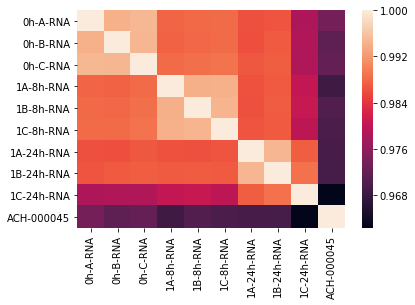

In [211]:
sns.heatmap(DMSO.T.corr(), 
            xticklabels=DMSO.index.values,
            yticklabels=DMSO.index.values)

### A quick detour to look for clustering

In [212]:
prev = prev.set_index("gene_id")

In [213]:
data = pd.concat([prev.T.drop('transcript_id(s)').astype(np.float).apply(lambda x: np.log2(x+1)), DMSO])

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [214]:
metadata = tc.get(name='sample-info-19q2-3c18', file='achiles_sample_info_full')

In [215]:
data.shape

(1298, 58813)

In [216]:
testlabels = ['Leukemia']*10
trainlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in data.index[:1288]]

In [217]:
data = data.dropna(1)

In [218]:
data.shape

(1298, 16606)

In [236]:
pca = PCA(50).fit(scale(data.values, axis=0, with_std=False))
dimred = pca.transform(scale(data.values, axis=0, with_std=False))

In [237]:
dimred.shape

(1298, 50)

In [221]:
# learn KNN classifier to the metadata diseases
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(dimred[:-10], trainlabels) 
predicted = neigh.predict(dimred[-10:])

In [222]:
predicted

array(['leukemia', 'leukemia', 'leukemia', 'leukemia', 'leukemia',
       'leukemia', 'leukemia', 'leukemia', 'leukemia', 'leukemia'],
      dtype='<U25')

In [223]:
data

,ENSG00000000003.14,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.12,ENSG00000001167.14,ENSG00000001460.17,...,ENSG00000283787.1,ENSG00000283980.1,ENSG00000284308.1,ENSG00000284491.2,ENSG00000284662.1,ENSG00000284723.1,ENSG00000284733.1,ENSG00000284753.1,ENSG00000284770.1,ENSG00000285077.1
ACH-001097,0.000000,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,2.150560,0.925999,...,1.275007,0.000000,1.565597,5.713971,0.000000,0.000000,0.000000,2.980025,5.132988,0.443607
ACH-001485,0.000000,5.755689,2.375735,2.634593,4.233428,0.545968,3.611172,3.068671,2.693766,0.310340,...,0.594549,0.000000,1.049631,3.675816,0.000000,0.000000,0.000000,3.393691,3.646163,0.378512
ACH-001396,2.883621,4.471838,2.347666,3.392317,0.495695,0.000000,4.731726,3.500802,2.643856,2.555816,...,0.000000,0.000000,3.478972,3.514753,0.000000,0.000000,0.000000,4.228819,5.098032,0.632268
ACH-001804,4.934988,6.635464,1.929791,2.503349,0.000000,4.883621,6.772546,3.889474,4.139961,3.253989,...,0.014355,0.000000,1.910733,1.111031,0.000000,0.000000,0.000000,2.283922,4.288359,0.475085
ACH-000534,0.839960,5.376082,2.687061,4.440288,4.938286,0.536053,3.584963,2.935460,3.157044,0.748461,...,2.166715,0.000000,2.653060,0.000000,0.000000,0.000000,0.000000,1.333424,4.841470,3.904966
ACH-000742,3.722466,6.029674,2.192194,2.533563,0.150560,5.933809,6.973382,5.192194,3.258519,3.428946,...,0.000000,0.000000,1.516015,1.448901,0.000000,0.000000,0.000000,1.526069,4.494416,0.941106
ACH-000836,4.632268,6.704180,2.792855,4.079805,0.097611,1.150560,5.729553,4.802193,4.372256,3.157044,...,0.176323,1.871844,1.111031,4.263786,0.000000,0.000000,0.000000,2.983678,4.743623,2.650765
ACH-000545,4.251719,5.651052,3.440952,3.275007,1.541019,6.659496,6.478648,5.566206,3.927896,2.742006,...,0.000000,0.000000,2.980025,0.000000,0.000000,0.000000,0.000000,2.899176,5.453847,3.950468
ACH-001850,4.844988,8.068993,1.280956,2.757023,0.000000,1.655352,6.268472,4.924100,4.154616,3.517276,...,0.014355,0.000000,1.137504,0.042644,0.000000,0.000000,0.000000,1.521051,3.477677,1.959770
ACH-000470,3.681449,7.294896,2.400538,2.849999,0.956057,0.238787,6.028569,5.868390,3.866908,2.773996,...,0.014355,0.000000,1.327687,0.000000,0.275007,0.000000,0.275007,3.711495,4.500802,1.157044


In [224]:
colors=[0]*1288
colors.extend([1,2,1,2,1,2,1,1,1,3])

In [225]:
dimred = TSNE(2,150).fit_transform(dimred)

In [226]:
len(colors)

1298

In [227]:
dimred.shape

(1298, 2)

In [230]:
scatter(dimred, labels=trainlabels+testlabels, colors=colors, radi=0.4)

In [231]:
MS2 = MS2.loc[MS2.index.values[[0,1,2,5,10,15,6,11,16,7,12,17,3,8,13,4,9,14]]][MS2.columns.values[:-6]]

ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=18 with svd_solver='full'

In [239]:
MS2red = pca.transform(scale(MS2.values, axis=0, with_std=False))

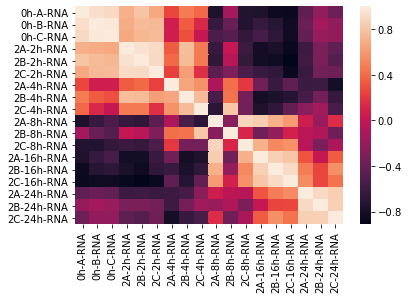

In [243]:
sns.heatmap(np.corrcoef(MS2red), 
            xticklabels=MS2.index.values,
            yticklabels=MS2.index.values)

In [244]:
JQ1 = JQ1[JQ1.columns.values[:-6]]

In [246]:
JQ1red = pca.transform(scale(JQ1.values, axis=0, with_std=False))

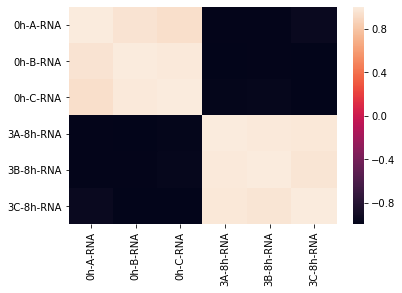

In [247]:
sns.heatmap(np.corrcoef(JQ1red), 
            xticklabels=JQ1.index.values,
            yticklabels=JQ1.index.values)

In [248]:
MS2_JQ1 = MS2_JQ1[MS2_JQ1.columns.values[:-6]]

In [251]:
MS2_JQ1red = pca.transform(scale(MS2_JQ1.values, axis=0, with_std=False))

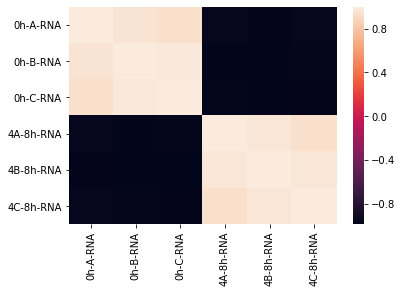

In [252]:
sns.heatmap(np.corrcoef(MS2_JQ1red),
            xticklabels=MS2_JQ1.index.values,
            yticklabels=MS2_JQ1.index.values)

## Getting the Core TF information

In [253]:
ctf=pd.read_csv('CTF.csv',header=None)[0].values.tolist()
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'IKAROS',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [254]:
genenames, notparsed = convertGenes(counts.columns.values)

6 could not be parsed... we don't have all genes already


In [255]:
genenames = np.array(genenames).tolist()

In [256]:
ctfpos = [genenames.index(val) for val in ctf if val in genenames]
notctfpos = [i for i, val in enumerate(genenames) if val not in ctf]

We find a CTF not in the dataset

In [257]:
[val for val in ctf if val not in genenames]

['IKAROS']

In [258]:
ctf.remove('IKAROS')

# Let's look at how they change accross time

how core transcription factors change accross time when the cell is with MS2 Condition

first line is avg count of CTF and line 2 is avg count of protein coding genes 

In [259]:
ctf_var = MS2repA.values[:,ctfpos].mean(1)
mean_var = MS2repA.values.mean(1)

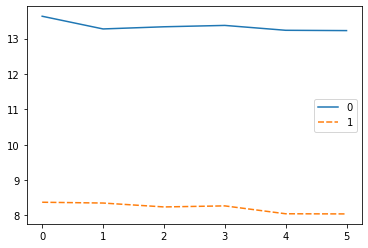

In [336]:
sns.lineplot(data=[ctf_var, mean_var])

In [337]:
ctf_var = MS2repB.values[:,ctfpos].mean(1)
mean_var = MS2repB.values.mean(1)

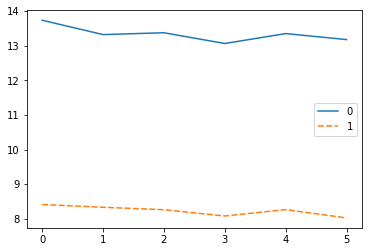

In [338]:
sns.lineplot(data=[ctf_var, mean_var])

# we can verify per tf 

but we expect to find the same results

In [339]:
ctf.append('all other gene coding')

In [260]:
from bokeh.models import Legend, LegendItem

ctf_var = MS2repC.values[:,ctfpos]
mean_var = MS2repC.values[:,notctfpos].mean(1)
data = np.vstack((ctf_var.T, mean_var.T))
source = ColumnDataSource(data=dict(
    y=data.tolist(),
    x=[np.linspace(0, data.shape[1]-1, data.shape[1]).tolist()]*data.shape[0],
    color= viridis(data.shape[0]),
    name=ctf
))
p = figure()
r = p.multi_line('x','y',color='color',hover_line_color='blue', source=source)
legend = Legend(items=[LegendItem(label=val, renderers=[r], index=i) for i, val in enumerate(ctf)])
p.add_layout(legend)
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('TF', '@name'),
]))
show(p)

## DESEQ ANALYSIS

In [297]:
# biggest change genes across time point
# GSEA
# counts = pd.read_csv("data/expression.MAX_AMLproject.counts.tsv", sep='\t')
 counts = pd.read_csv("data/expression.MAX_AMLproject.tpm.tsv", sep='\t')
#transcripts = pd.read_csv("data/expression.MAX_AMLproject.transcripts.tsv", sep='\t')b

In [298]:
counts = counts.iloc[filtered]

In [299]:
#filter some more
toremove = np.argwhere(counts[counts.columns.values[2:]].values.var(1)==0)

In [300]:
counts = counts.drop(counts.index[toremove.ravel()],0)
counts = counts.reset_index()
counts = counts.drop(columns='index')

In [301]:
counts = counts.drop('transcript_id(s)',1)

In [302]:
counts[counts.columns[1:]]

,0h-A-RNA,0h-B-RNA,0h-C-RNA,1A-24h-RNA,1A-8h-RNA,1B-24h-RNA,1B-8h-RNA,1C-24h-RNA,1C-8h-RNA,2A-16h-RNA,...,2C-24h-RNA,2C-2h-RNA,2C-4h-RNA,2C-8h-RNA,3A-8h-RNA,3B-8h-RNA,3C-8h-RNA,4A-8h-RNA,4B-8h-RNA,4C-8h-RNA
0,0.00,0.26,0.07,0.00,0.23,0.00,0.00,0.00,0.00,0.00,...,0.06,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.06,0.00
1,49.76,46.59,51.23,42.42,44.60,38.93,53.61,45.46,62.35,38.04,...,43.24,51.43,58.62,53.86,55.62,50.72,55.28,57.90,57.35,53.80
2,2.94,2.76,2.89,3.46,3.75,3.75,4.37,2.82,4.65,3.77,...,4.58,4.92,4.41,3.80,3.72,4.55,4.41,4.83,4.17,4.59
3,12.40,10.77,13.68,8.13,11.75,8.18,11.87,7.81,9.86,11.12,...,7.36,9.67,6.70,8.96,8.64,6.19,6.72,4.54,5.89,6.37
4,28.63,34.01,31.41,34.33,18.72,32.27,16.55,30.66,18.25,32.84,...,38.17,26.24,17.03,17.17,6.03,6.50,5.37,5.79,3.95,5.21
5,0.09,0.21,0.11,0.68,0.08,0.69,0.03,0.50,0.64,0.64,...,0.43,0.04,0.16,0.22,0.36,0.23,0.03,0.36,0.12,0.24
6,43.28,54.30,49.61,65.81,44.79,58.38,44.29,39.46,39.39,53.63,...,65.88,46.06,36.20,35.30,37.72,24.76,30.24,33.68,31.29,37.68
7,2.51,4.90,3.62,3.17,5.15,5.78,7.00,7.96,6.28,9.40,...,4.47,6.68,4.94,6.43,6.92,17.04,7.55,9.62,10.47,8.69
8,19.77,27.61,24.91,24.17,34.33,24.60,32.26,23.68,28.77,26.08,...,26.64,19.35,14.13,25.92,48.97,44.29,48.38,38.48,44.64,41.78
9,1.51,1.58,1.32,1.39,1.34,3.03,1.94,4.58,1.42,2.98,...,1.65,1.64,1.43,2.34,0.31,1.40,0.64,0.23,0.26,0.25


In [303]:
counts[counts.columns[1:]] = counts[counts.columns[1:]].astype(float).apply(lambda x: np.log2(x+1))
counts[counts.columns[1:]] = scale(counts[counts.columns[1:]].values, axis=1, with_std=False)

In [304]:
START = '0'
MS2 = '2'
JQ1 = '3'
MS2_JQ1 = '4'
DMSO = '1'

In [305]:
DMSO = [val[0]==DMSO for val in counts.columns.values]
DMSO_t = [int(val.split('-')[1][:-1]) if val[0]==DMSO else 0 for val in counts.columns.values]
START = [val[0]==START for val in counts.columns.values]
MS2_t = [int(val.split('-')[1][:-1]) if val[0]==MS2 else 0 for val in counts.columns.values]
MS2_24 = [val == 24 for val in MS2_t]
MS2 = [val[0]==MS2 for val in counts.columns.values]
MS2_JQ1_t = [int(val.split('-')[1][:-1]) if val[0]==MS2_JQ1 else 0 for val in counts.columns.values]
MS2_JQ1 = [val[0]==MS2_JQ1 for val in counts.columns.values]
JQ1_t = [int(val.split('-')[1][:-1]) if val[0]==JQ1 else 0 for val in counts.columns.values]
JQ1 = [val[0]==JQ1 for val in counts.columns.values]

In [312]:
design = pd.DataFrame(index=counts.columns.values[1:], 
                      columns=['START','DMSO','DMSO_t','MS2','MS2_t','MS2_24', 'MS2_JQ1', 'MS2_JQ1_t', 'JQ1', 'JQ1_t'], 
                      data=np.array([START, DMSO, DMSO_t, MS2, MS2_t, MS2_24, MS2_JQ1, MS2_JQ1_t, JQ1, JQ1_t]).T[1:])

In [314]:
design.index = 'X' + design.index.astype(str).str.replace('-','.')

In [315]:
design

,START,DMSO,DMSO_t,MS2,MS2_t,MS2_24,MS2_JQ1,MS2_JQ1_t,JQ1,JQ1_t
X0h.A.RNA,1,0,0,0,0,0,0,0,0,0
X0h.B.RNA,1,0,0,0,0,0,0,0,0,0
X0h.C.RNA,1,0,0,0,0,0,0,0,0,0
X1A.24h.RNA,0,1,0,0,0,0,0,0,0,0
X1A.8h.RNA,0,1,0,0,0,0,0,0,0,0
X1B.24h.RNA,0,1,0,0,0,0,0,0,0,0
X1B.8h.RNA,0,1,0,0,0,0,0,0,0,0
X1C.24h.RNA,0,1,0,0,0,0,0,0,0,0
X1C.8h.RNA,0,1,0,0,0,0,0,0,0,0
X2A.16h.RNA,0,0,0,1,16,0,0,0,0,0


In [316]:
deseq = pyDESeq2.pyDESeq2(count_matrix=counts,
                          design_matrix = design,
         design_formula="~ START + MS2_t",
         gene_column="gene_id")

3.0.4


In [317]:
deseq.run_deseq()

2019-07-10 04:36:48::WARNING  R[write to console]: Error in DESeqDataSet(se, design = design, ignoreRank) : 
  some values in assay are negative
Calls: <Anonymous> -> DESeqDataSet



RRuntimeError: Error in DESeqDataSet(se, design = design, ignoreRank) : 
  some values in assay are negative
Calls: <Anonymous> -> DESeqDataSet


In [374]:
deseq.get_deseq_result()

In [375]:
MS2res = deseq.deseq_result

In [376]:
MS2res.pvalue = np.nan_to_num(np.array(MS2res.pvalue), 1)
MS2res.log2FoldChange = np.nan_to_num(np.array(MS2res.log2FoldChange), 0)

In [377]:
MS2res.gene_id = convertGenes(MS2res.gene_id)[0]

0 could not be parsed... we don't have all genes already


In [378]:
show(volcano(MS2res,tohighlight=ctf))

In [395]:
deseq = pyDESeq2.pyDESeq2(count_matrix=counts.drop('transcript_id(s)',1),
                          design_matrix = design,
         design_formula="~ START + MS2_24",
         gene_column="gene_id")
deseq.run_deseq()
deseq.get_deseq_result()
MS2res = deseq.deseq_result

3.0.4


2019-07-07 03:26:14::WARNING  R[write to console]:   the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

2019-07-07 03:26:17::WARNING  R[write to console]: estimating size factors

2019-07-07 03:26:18::WARNING  R[write to console]: estimating dispersions

2019-07-07 03:26:18::WARNING  R[write to console]: gene-wise dispersion estimates

2019-07-07 03:26:22::WARNING  R[write to console]: mean-dispersion relationship

2019-07-07 03:26:22::WARNING  R[write to console]: final dispersion estimates

2019-07-07 03:26:26::WARNING  R[write to console]: fitting model and testing

2019-07-07 03:26:31::WARNING  R[write to console]: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

2019-07-07 03:26:31::WAR

In [396]:
MS2res.pvalue = np.nan_to_num(np.array(MS2res.pvalue), 1)
MS2res.log2FoldChange = np.nan_to_num(np.array(MS2res.log2FoldChange), 0)
MS2res.gene_id = convertGenes(MS2res.gene_id)[0]
show(volcano(MS2res,tohighlight=ctf))

0 could not be parsed... we don't have all genes already


In [379]:
deseq = pyDESeq2.pyDESeq2(count_matrix=counts.drop('transcript_id(s)',1),
                          design_matrix = design,
         design_formula="~ START + JQ1",
         gene_column="gene_id")
deseq.run_deseq()
deseq.get_deseq_result()
JQ1res = deseq.deseq_result

3.0.4


2019-07-07 02:52:27::WARNING  R[write to console]:   the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

2019-07-07 02:52:30::WARNING  R[write to console]: estimating size factors

2019-07-07 02:52:30::WARNING  R[write to console]: estimating dispersions

2019-07-07 02:52:31::WARNING  R[write to console]: gene-wise dispersion estimates

2019-07-07 02:52:37::WARNING  R[write to console]: mean-dispersion relationship

2019-07-07 02:52:37::WARNING  R[write to console]: final dispersion estimates

2019-07-07 02:52:43::WARNING  R[write to console]: fitting model and testing

2019-07-07 02:52:48::WARNING  R[write to console]: -- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

2019-07-07 02:52:48::WA

In [380]:
JQ1res.pvalue = np.nan_to_num(np.array(JQ1res.pvalue), 1)
JQ1res.log2FoldChange = np.nan_to_num(np.array(JQ1res.log2FoldChange), 0)
JQ1res.gene_id = convertGenes(JQ1res.gene_id)[0]
show(volcano(JQ1res,tohighlight=ctf))

0 could not be parsed... we don't have all genes already


In [381]:
deseq = pyDESeq2.pyDESeq2(count_matrix=counts.drop('transcript_id(s)',1),
                          design_matrix = design,
         design_formula="~ START + MS2_JQ1",
         gene_column="gene_id")
deseq.run_deseq()
deseq.get_deseq_result()
MS2_JQ1 = deseq.deseq_result

3.0.4


2019-07-07 02:53:36::WARNING  R[write to console]:   the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

2019-07-07 02:53:37::WARNING  R[write to console]: estimating size factors

2019-07-07 02:53:37::WARNING  R[write to console]: estimating dispersions

2019-07-07 02:53:37::WARNING  R[write to console]: gene-wise dispersion estimates

2019-07-07 02:53:41::WARNING  R[write to console]: mean-dispersion relationship

2019-07-07 02:53:41::WARNING  R[write to console]: final dispersion estimates

2019-07-07 02:53:44::WARNING  R[write to console]: fitting model and testing

2019-07-07 02:53:50::WARNING  R[write to console]: -- replacing outliers and refitting for 5 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

2019-07-07 02:53:50::WAR

In [382]:
MS2_JQ1.pvalue = np.nan_to_num(np.array(MS2_JQ1.pvalue), 1)
MS2_JQ1.log2FoldChange = np.nan_to_num(np.array(MS2_JQ1.log2FoldChange), 0)
MS2_JQ1.gene_id = convertGenes(MS2_JQ1.gene_id)[0]
show(volcano(MS2_JQ1,tohighlight=ctf))

0 could not be parsed... we don't have all genes already


## Results

It seems looking at both plottings of raw RNA data and Differential Expression analysis, that the RNA seq experiment is sound.

However it does not completly match to the theory. We can see some of the CTF as showing differential expression but they are not the most differentially expressed ones. 
This could amount to noise. 

It seems however, looking at the TNSE and MDS plots, that the samples underwent a transcriptional adaptation to the presence of different element. This state change could be attributable to the CTFs. But it seemed to be a transcriptional adaptation rather than transcriptional collapse. Moreover, given the experimental set up (using PCR, renormalizing the RNA) it might be difficult to see transcriptional collaps.

### DESEQ2

you might have seen that more complex variance analysis can be achieved. However it seems that with the little data at hand and the assumption that these more complex models will achieve, staying on a simpler differential expression formula allows better results. I have tried a few and it seemed to confirm this suspicion (or I would need to provide a better model than DESEQ has to offer) limma.voom?